<a href="https://colab.research.google.com/github/visshal2301/AdvanceSpark_GoogleColab/blob/main/1_ReadQueryPlanSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [4]:
!pip install -q pyngrok

In [2]:
spark = SparkSession.builder \
       .master("local[*]") \
       .appName("Colab") \
       .config('spark.ui.port', '4050') \
       .getOrCreate()
spark

Transaction Data

In [6]:
# prompt: need to see spark UI using colab
from pyngrok import ngrok
from google.colab import userdata

# Get the ngrok authtoken from Colab secrets
# You need to add your ngrok authtoken to Colab's secrets with the name 'NGROK_AUTH_TOKEN'
ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_auth_token)

public_url = ngrok.connect(4050).public_url
print(f"Spark UI: {public_url}")

Spark UI: https://4357741cf2a7.ngrok-free.app


In [3]:
transactions_file = "/content/drive/MyDrive/data/data_skew/transactions.parquet"
df_transactions = spark.read.parquet(transactions_file)
df_transactions.show()
df_transactions.rdd.getNumPartitions()

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|   cust_id|start_date|  end_date|         txn_id|      date|year|month|day| expense_type|   amt|        city|
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|   10|  7|Entertainment| 10.42|      boston|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|    3| 27| Motor/Travel| 44.34|    portland|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TETSXIK4BLXHJ6W|2011-04-11|2011|    4| 11|Entertainment|  3.18|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TQKL1QFJY3EM8LO|2018-02-22|2018|    2| 22|    Groceries|268.97| los_angeles|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYL6DFP09PPXMVB|2010-10-16|2010|   10| 16|Entertainment|  2.66|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|T1SMX9EUG21BBSE|2015-02-11|2015|    2| 11|    Education| 54.14|    portland|
|

12

In [5]:
customers_file = "/content/drive/MyDrive/data/data_skew/customers.parquet"
df_customers = spark.read.parquet(customers_file)
df_customers.show()


+----------+--------------+---+------+----------+-----+------------+
|   cust_id|          name|age|gender|  birthday|  zip|        city|
+----------+--------------+---+------+----------+-----+------------+
|C007YEYTX9|  Aaron Abbott| 34|Female| 7/13/1991|97823|      boston|
|C00B971T1J|  Aaron Austin| 37|Female|12/16/2004|30332|     chicago|
|C00WRSJF1Q|  Aaron Barnes| 29|Female| 3/11/1977|23451|      denver|
|C01AZWQMF3| Aaron Barrett| 31|  Male|  7/9/1998|46613| los_angeles|
|C01BKUFRHA|  Aaron Becker| 54|  Male|11/24/1979|40284|   san_diego|
|C01RGUNJV9|    Aaron Bell| 24|Female| 8/16/1968|86331|      denver|
|C01USDV4EE|   Aaron Blair| 35|Female|  9/9/1974|80078|    new_york|
|C01WMZQ7PN|   Aaron Brady| 51|Female| 8/20/1994|52204|philadelphia|
|C021567NJZ|  Aaron Briggs| 57|  Male| 3/10/1990|22008|philadelphia|
|C023M6MKR3|   Aaron Bryan| 29|  Male| 4/10/1976|05915|philadelphia|
|C0248N0EK3|  Aaron Burton| 26|Female| 8/27/1964|50477| los_angeles|
|C02C54RPNL|  Aaron Burton| 46|  M

Spark's Query Plans
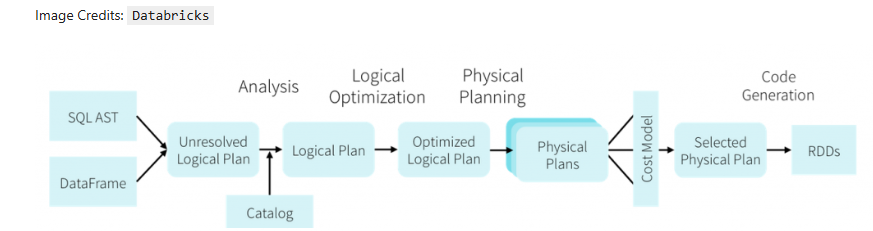

Narrow Transformations

* filter rows where city='boston'
*  add a new column: adding first_name and last_name
*  alter an exisitng column: adding 5 to age column
*  select relevant columns








In [7]:
df_narrow_transform = (
    df_customers
    .filter(F.col("city") == "boston")
    .withColumn("first_name", F.split("name", " ").getItem(0))
    .withColumn("last_name", F.split("name", " ").getItem(1))
    .withColumn("age", F.col("age") + F.lit(5))
    .select("cust_id", "first_name", "last_name", "age", "gender", "birthday")
)

df_narrow_transform.show(5, False)
df_narrow_transform.explain(True)

+----------+----------+---------+----+------+---------+
|cust_id   |first_name|last_name|age |gender|birthday |
+----------+----------+---------+----+------+---------+
|C007YEYTX9|Aaron     |Abbott   |39.0|Female|7/13/1991|
|C08XAQUY73|Aaron     |Lambert  |59.0|Female|11/5/1966|
|C094P1VXF9|Aaron     |Lindsey  |29.0|Male  |9/21/1990|
|C097SHE1EF|Aaron     |Lopez    |27.0|Female|4/18/2001|
|C0DTC6436T|Aaron     |Schwartz |57.0|Female|7/9/1962 |
+----------+----------+---------+----+------+---------+
only showing top 5 rows

== Parsed Logical Plan ==
'Project ['cust_id, 'first_name, 'last_name, 'age, 'gender, 'birthday]
+- Project [cust_id#68, name#69, (cast(age#70 as double) + cast(5 as double)) AS age#131, gender#71, birthday#72, zip#73, city#74, first_name#112, last_name#121]
   +- Project [cust_id#68, name#69, age#70, gender#71, birthday#72, zip#73, city#74, first_name#112, split(name#69,  , -1)[1] AS last_name#121]
      +- Project [cust_id#68, name#69, age#70, gender#71, birthday#7

Analysing the Physical plan for narrow transformation
*   == Physical Plan ==
*(1) Project [cust_id#68, split(name#69,  , -1)[0] AS first_name#112, split(name#69,  , -1)[1] AS last_name#121, (cast(age#70 as double) + 5.0) AS age#131, gender#71, birthday#72]
+- *(1) Filter (isnotnull(city#74) AND (city#74 = boston))
   +- *(1) ColumnarToRow
      +- FileScan parquet [cust_id#68,name#69,age#70,gender#71,birthday#72,city#74] Batched: true, DataFilters: [isnotnull(city#74), (city#74 = boston)], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/data_skew/customers.parquet], PartitionFilters: [], PushedFilters: [IsNotNull(city), EqualTo(city,boston)], ReadSchema: struct<cust_id:string,name:string,age:string,gender:string,birthday:string,city:string>




*   FileScan parquet: Reads columns (cust_id, name, age, gender, birthday, city) from the Parquet file, applying filters to only load rows where city is not null and equals "boston".
*   ColumnarToRow: Converts the columnar format from Parquet into row format for further processing.


*  Filter: Further ensures only rows with city = boston are processed.
*   Project: Selects and transforms columns:
cust_id
Splits name into first_name and last_name
Adds 5 to age and casts it to double
gender
birthday

This plan is efficient because it pushes filters down to the scan level, minimizing the amount of data read from disk. The transformations and projections are performed after filtering, reducing computation.






**Wide Transformations**
1. Repartition
2. Coalesce
3. Joins
4. GroupBy
5. count
6. countDistinct
7. sum




In [8]:
df_transactions.repartition(24).explain(True)

== Parsed Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(24), REPARTITION_BY_NUM, [plan_id=80]
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Locatio

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(24), REPARTITION_BY_NUM, [plan_id=80]
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/data_skew/transactions.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<cust_id:string,start_date:string,end_date:string,txn_id:string,date:string,year:string,mon...


**Analysing Plan**

This Spark physical plan describes how data is read and repartitioned from a Parquet file:


*   FileScan parquet: Reads columns (cust_id, start_date, end_date, txn_id, date, year, month, day, expense_type, amt, city) from the Parquet file located at /content/drive/MyDrive/data/data_skew/transactions.parquet. No filters are applied, so all rows are read.
*   Exchange(Shuffle) RoundRobinPartitioning(24): After reading, the data is repartitioned into 24 partitions using round-robin distribution. This is often done to balance data across executors for parallel processing.
*   AdaptiveSparkPlan isFinalPlan=false: Indicates that Spark's adaptive query execution is in progress and the plan may change based on runtime statistics.

This plan is efficient for distributing data evenly across the cluster, especially when no filtering is required before processing.




**Coalesce**

In [9]:
df_transactions.coalesce(5).explain(True)

== Parsed Logical Plan ==
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
Coalesce 5
+- *(1) ColumnarToRow
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/data_skew/tra

**Analysing Plan**

*   FileScan parquet: Reads all columns from the Parquet file /content/drive/MyDrive/data/data_skew/transactions.parquet. No filters are applied, so all data is loaded.
*   ColumnarToRow: Converts the columnar format from Parquet to row format for further processing.
*   Coalesce 5: Combines the data into 5 partitions, which can help reduce the number of output files or optimize resource usage for downstream operations.





**Why doesn't .coalesce() explicitly show the partitioning scheme?**

.coalesce doesn't show the partitioning scheme e.g. RoundRobinPartitioning because:

The operation only minimizes data movement by merging into fewer partitions, it doesn't do any shuffling.
Because no shuffling is done, the partitioning scheme remains the same as the original DataFrame and Spark doesn't include it explicitly in it's plan as the partitioning scheme is unaffected by .coalesce

In [ ]:
spark.stop()